# KMeans Clustering

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn import preprocessing

%matplotlib inline

def printmd(string):
    display(Markdown(string))

## Data Load

In [2]:
TwoDim = pd.read_csv('TwoDimHard.csv')

# Convert to a numpy array
Two = np.array(TwoDim[['X.1','X.2']])

display(TwoDim.head(10))

,ID,X.1,X.2,cluster
0,1,0.276724,0.793762,1
1,2,0.346407,0.797695,1
2,3,0.296033,0.845381,1
3,4,0.333519,0.774505,1
4,5,0.347625,0.737573,1
5,6,0.443881,0.760030,1
6,7,0.358073,0.736421,1
7,8,0.305019,0.722984,1
8,9,0.235237,0.764224,1
9,10,0.304484,0.720066,1


In [3]:
TwoDim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
ID         400 non-null int64
X.1        400 non-null float64
X.2        400 non-null float64
cluster    400 non-null int64
dtypes: float64(2), int64(2)
memory usage: 12.6 KB


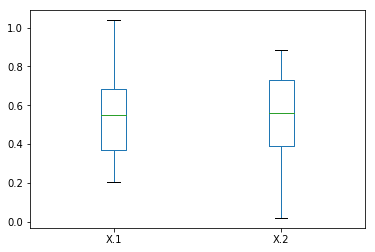

In [4]:
TwoDim.drop(columns = ['ID', 'cluster']).plot(kind = 'box')

In [257]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, points.shape[0] + n)[points.shape[0] + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    #print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeansFormal(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    
    return pd.DataFrame({'RowID' : [i for i in range(len(clusters))], 'Cluster' : clusters})

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    SSE, SSB = 0, 0
    SSE_cluster = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        SSE += temp
        SSE_cluster.append(temp)
        
    return SSE, SSB, SSE_cluster

def softmax(x):

    x = x - np.max(x, axis = x.ndim - 1, keepdims=True)
    x = np.exp(x) / np.sum(np.exp(x), axis = x.ndim - 1, keepdims = True)
    
    return x


# Sample Output

In [259]:
KMeansFormal(4, Two).head()

,Cluster,RowID
0,2,0
1,2,1
2,2,2
3,2,3
4,2,4


## True Cluster Membership

SSB : 95.400839
SSE : 39.600296
Cluster-wise SSE:
Cluster 1: 4.500000
Cluster 2: 8.410000
Cluster 3: 13.730000
Cluster 4: 12.950000


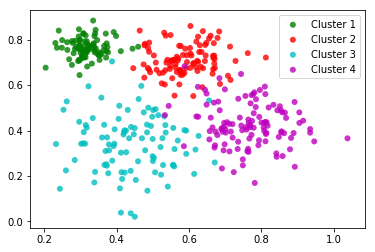

In [85]:
groups = TwoDim.groupby('cluster')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group['X.1'], group['X.2'],alpha=0.8, c=colors[name], edgecolors='none', label='Cluster '+str(name))
ax.legend()


printmd('## True Cluster Membership')
SSE, SSB, SSE_cluster = calculateMeasures(Two, TwoDim.cluster.values, updateCentroids(Two, TwoDim.cluster.values, np.zeros((4,Two.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
plt.show()

In [145]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(4, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 40.030522 & Mean SSB : 95.352469


37.97 | 96.34    85
50.82 | 91.24     5
53.65 | 84.46     2
51.13 | 90.8      1
50.79 | 90.84     1
50.77 | 91.06     1
53.9 | 90.7       1
50.78 | 91.12     1
51.37 | 91.93     1
50.79 | 90.85     1
54.56 | 84.19     1
dtype: int64

## Clustering Plot k = 4

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 9.480000
Cluster 2: 11.190000
Cluster 3: 11.770000
Cluster 4: 5.530000

Iteration till convergence : 8


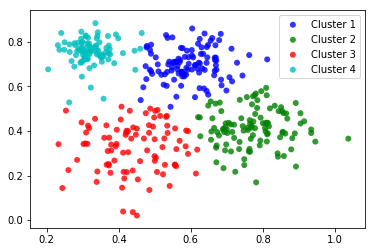

In [143]:
centroids, iterations, clusters = KMeans(4, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 4')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [136]:
new_clusters = []
for i in clusters:
    if i == 3:
        new_clusters.append(1)
    elif i == 2:
        new_clusters.append(2)
    elif i == 1:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,2,4,0
2,0,98,2,8
3,0,0,88,2
4,0,0,3,104


## K = 3

In [149]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(3, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 53.893691 & Mean SSB : 88.441353


53.88 | 90.64    40
53.9 | 90.7      27
53.65 | 84.46    17
53.74 | 84.41     9
53.78 | 84.39     3
53.92 | 84.42     2
59.4 | 68.06      1
54.55 | 84.13     1
dtype: int64

## Clustering Plot k = 3

SSB : 90.636953
SSE : 53.881737
Cluster-wise SSE:
Cluster 1: 12.220000
Cluster 2: 13.810000
Cluster 3: 27.850000

Iteration till convergence : 6


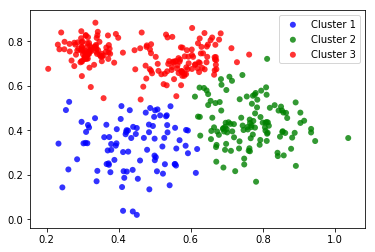

In [147]:
centroids, iterations, clusters = KMeans(3, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 3')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [ ]:
new_clusters = []
for i in clusters:
    if i == 3:
        new_clusters.append(1)
    elif i == 2:
        new_clusters.append(2)
    elif i == 1:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


In [49]:
# Sampling Centroids
SSE, SSB = [], []
for i in range(100):
    cent = reallyreallyInitializeCentroids(Two, 4)
    centroids, iterations, clusters = KMeans(4, Two, cent)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

Centroids replaced 175 time(s).
Centroids replaced 152 time(s).
Centroids replaced 70 time(s).
Centroids replaced 147 time(s).
Centroids replaced 288 time(s).
Centroids replaced 140 time(s).
Centroids replaced 260 time(s).
Centroids replaced 196 time(s).
Centroids replaced 128 time(s).
Centroids replaced 182 time(s).
Centroids replaced 157 time(s).
Centroids replaced 92 time(s).
Centroids replaced 81 time(s).
Centroids replaced 149 time(s).
Centroids replaced 233 time(s).
Centroids replaced 86 time(s).
Centroids replaced 128 time(s).
Centroids replaced 192 time(s).
Centroids replaced 149 time(s).
Centroids replaced 155 time(s).
Centroids replaced 179 time(s).
Centroids replaced 247 time(s).
Centroids replaced 145 time(s).
Centroids replaced 273 time(s).
Centroids replaced 288 time(s).
Centroids replaced 191 time(s).
Centroids replaced 113 time(s).
Centroids replaced 179 time(s).
Centroids replaced 121 time(s).
Centroids replaced 260 time(s).
Centroids replaced 171 time(s).
Centroids re

Centroids replaced 196 time(s).


## Clustering Plot

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 9.480000
Cluster 2: 11.770000
Cluster 3: 11.190000
Cluster 4: 5.530000


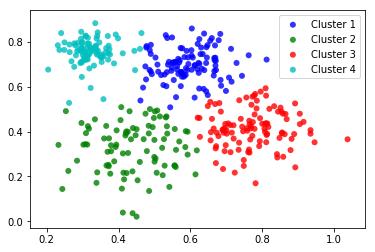

In [45]:
cent = reallyreallyInitializeCentroids(Two, 4)
centroids, iterations, clusters = KMeans(4, Two, cent)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))


plt.show()

## Ideal K Value

In [160]:
SSE_per_k = []
for j in range(1,11):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(100):
        centroids, iterations, clusters = KMeans(j, Two)
        t1, t2, _ = calculateMeasures(Two, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k.append(np.mean(SSE))

Calculating for k : 1
Calculating for k : 2
Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10


Text(0,0.5,'SSE')

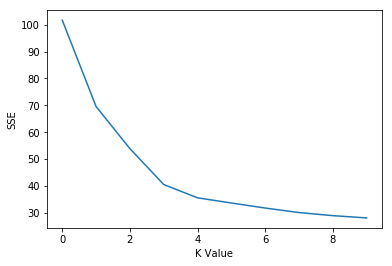

In [164]:
#SSE_per_k
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Wine Data Clustering

In [334]:
wine = pd.read_csv('winequality-red.csv', sep = ';')
Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide']))


scaler = preprocessing.MinMaxScaler()
scaler.fit(Wine_Base)
Wine_Norm = scaler.transform(Wine_Base)
Wine_Softmax = softmax(Wine_Base)

In [306]:
wine.quality.value_counts()


5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

# Non normalized data

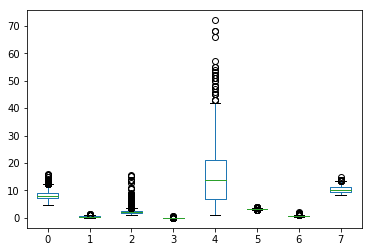

In [276]:
pd.DataFrame(Wine_Base).plot(kind = 'box')

In [277]:
centroids, iterations, clusters = KMeans(10, Wine_Base)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 2
4    1599
dtype: int64


SSB : 0.000000
SSE : 13933.522005
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 0.000000
Cluster 4: 13933.520000
Cluster 5: 0.000000
Cluster 6: 0.000000
Cluster 7: 0.000000
Cluster 8: 0.000000
Cluster 9: 0.000000
Cluster 10: 0.000000


In [278]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Base, k)
centroids, iterations, clusters = KMeans(k, Wine_Base, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 21
6     460
7     329
10    296
8     197
5     148
1     116
3      39
4       6
9       4
2       4
dtype: int64


SSB : 12984.104900
SSE : 4177.926952
Cluster-wise SSE:
Cluster 1: 346.220000
Cluster 2: 11.530000
Cluster 3: 195.200000
Cluster 4: 30.100000
Cluster 5: 403.330000
Cluster 6: 1215.140000
Cluster 7: 780.220000
Cluster 8: 516.340000
Cluster 9: 14.380000
Cluster 10: 665.470000


# Sampling with Conditions

In [279]:
SSE_per_k_Base = []
for j in range(3,20):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Base, j)
        centroids, iterations, clusters = KMeans(j, Wine_Base, cent)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base.append(np.mean(SSE))

Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10
Calculating for k : 11
Calculating for k : 12
Calculating for k : 13
Calculating for k : 14
Calculating for k : 15
Calculating for k : 16
Calculating for k : 17
Calculating for k : 18
Calculating for k : 19


Text(0,0.5,'SSE')

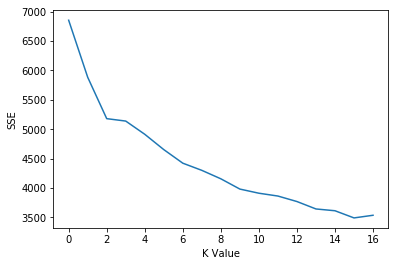

In [280]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

## Random Sampling

Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10
Calculating for k : 11
Calculating for k : 12
Calculating for k : 13
Calculating for k : 14
Calculating for k : 15
Calculating for k : 16
Calculating for k : 17
Calculating for k : 18
Calculating for k : 19


Text(0,0.5,'SSE')

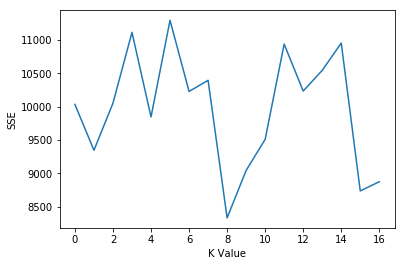

In [281]:
SSE_per_k_Base_Rand = []
for j in range(3,20):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        centroids, iterations, clusters = KMeans(j, Wine_Base)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base_Rand.append(np.mean(SSE))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base_Rand, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

Text(0,0.5,'SSE')

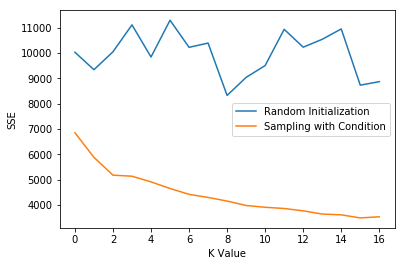

In [282]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.DataFrame({'Sampling with Condition': SSE_per_k_Base, 'Random Initialization' : SSE_per_k_Base_Rand}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Min-Max Normalizaed

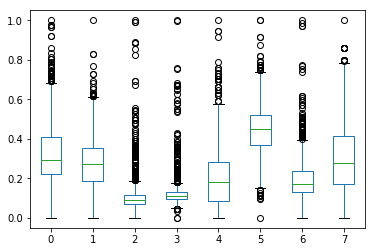

In [283]:
pd.DataFrame(Wine_Norm).plot(kind = 'box')

In [284]:
centroids, iterations, clusters = KMeans(10, Wine_Norm)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 26
9     558
4     300
2     250
3     228
10    199
6      35
1      29
dtype: int64


SSB : 384.548796
SSE : 366.720004
Cluster-wise SSE:
Cluster 1: 9.330000
Cluster 2: 57.820000
Cluster 3: 54.030000
Cluster 4: 72.600000
Cluster 5: 0.000000
Cluster 6: 14.230000
Cluster 7: 0.000000
Cluster 8: 0.000000
Cluster 9: 108.180000
Cluster 10: 50.530000


In [285]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 40
8     365
4     279
6     255
3     245
5     207
10    165
7      33
1      26
2      23
9       1
dtype: int64


SSB : 400.463171
SSE : 351.535590
Cluster-wise SSE:
Cluster 1: 7.770000
Cluster 2: 5.040000
Cluster 3: 56.490000
Cluster 4: 53.770000
Cluster 5: 47.800000
Cluster 6: 59.750000
Cluster 7: 13.430000
Cluster 8: 66.660000
Cluster 9: 0.000000
Cluster 10: 40.830000


In [286]:
SSE_per_k_Norm = []
for j in range(3,20):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Norm, j)
        centroids, iterations, clusters = KMeans(j, Wine_Norm, cent)
        t1, t2, _ = calculateMeasures(Wine_Norm, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Norm.append(np.mean(SSE))

Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10
Calculating for k : 11
Calculating for k : 12
Calculating for k : 13
Calculating for k : 14
Calculating for k : 15
Calculating for k : 16
Calculating for k : 17
Calculating for k : 18
Calculating for k : 19


Text(0,0.5,'SSE')

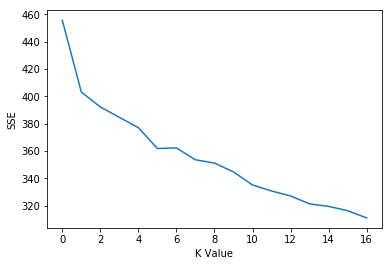

In [287]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Softmax Normalizaed

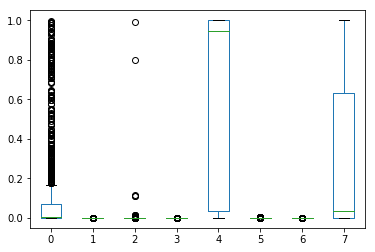

In [288]:
pd.DataFrame(Wine_Softmax).plot(kind = 'box')

In [290]:
centroids, iterations, clusters = KMeans(10, Wine_Softmax)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 9
1    969
7    506
8    122
5      2
dtype: int64


SSB : 898.341529
SSE : 211.591886
Cluster-wise SSE:
Cluster 1: 73.950000
Cluster 2: 0.000000
Cluster 3: 0.000000
Cluster 4: 0.000000
Cluster 5: 0.270000
Cluster 6: 0.000000
Cluster 7: 110.960000
Cluster 8: 26.410000
Cluster 9: 0.000000
Cluster 10: 0.000000


In [301]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Softmax, k)
centroids, iterations, clusters = KMeans(k, Wine_Softmax, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 8
9     849
2     286
10    106
6      87
7      75
3      70
8      67
4      41
5      16
1       2
dtype: int64


SSB : 909.112189
SSE : 86.528576
Cluster-wise SSE:
Cluster 1: 0.270000
Cluster 2: 22.160000
Cluster 3: 7.490000
Cluster 4: 4.200000
Cluster 5: 2.920000
Cluster 6: 7.420000
Cluster 7: 9.640000
Cluster 8: 6.620000
Cluster 9: 14.310000
Cluster 10: 11.500000


In [302]:
SSE_per_k_Soft = []
for j in range(3,20):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Softmax, j)
        centroids, iterations, clusters = KMeans(j, Wine_Softmax, cent)
        t1, t2, _ = calculateMeasures(Wine_Softmax, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Soft.append(np.mean(SSE))

Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10
Calculating for k : 11
Calculating for k : 12
Calculating for k : 13
Calculating for k : 14
Calculating for k : 15
Calculating for k : 16
Calculating for k : 17
Calculating for k : 18
Calculating for k : 19


Text(0,0.5,'SSE')

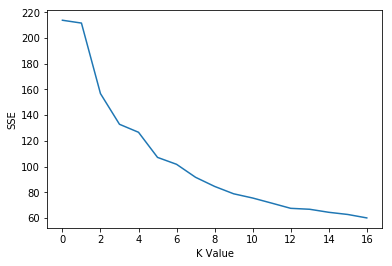

In [303]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

Text(17.2,0.5,'SSE')

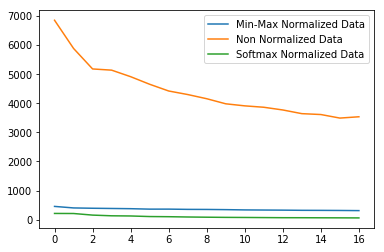

In [304]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
pd.DataFrame({'Non Normalized Data' : SSE_per_k_Base, 'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

<IPython.core.display.Javascript object>


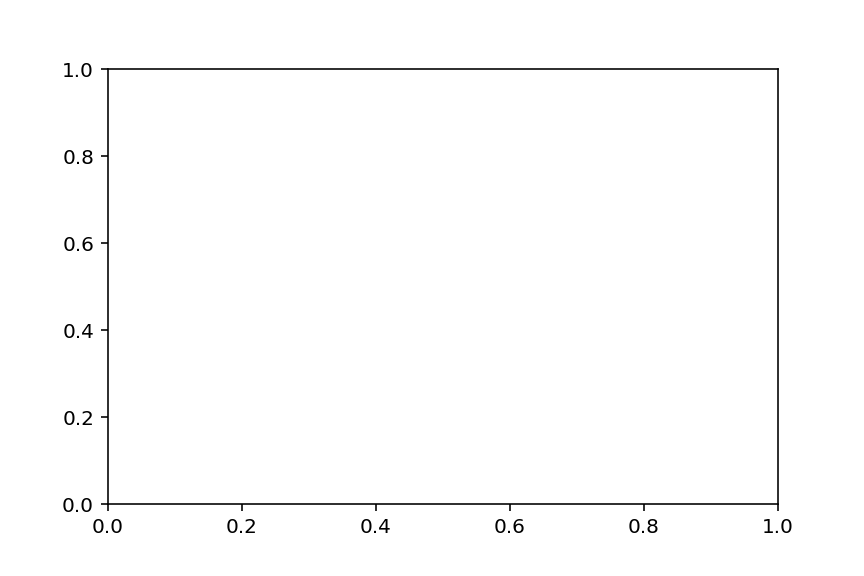

<IPython.core.display.Javascript object>


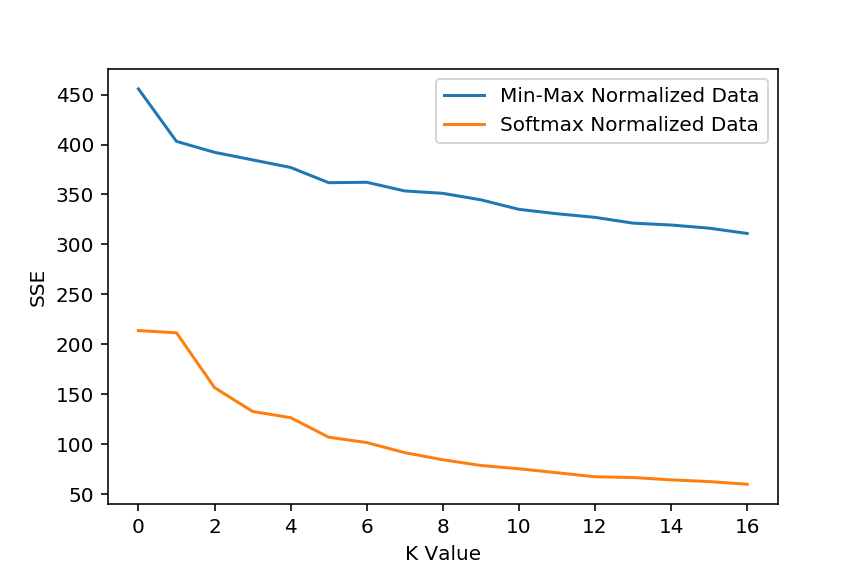

In [468]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.DataFrame({'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
fig.show()

Text(0,0.5,'SSE')

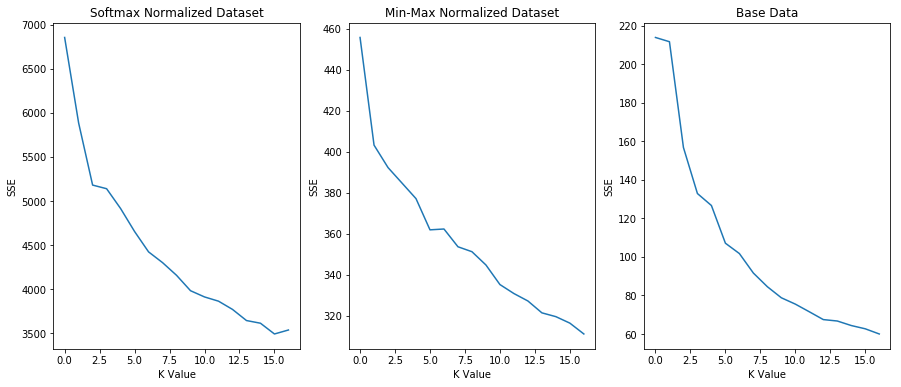

In [321]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line', ax =  axs[2], title =  'Base Data')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line', ax =  axs[1], title =  'Min-Max Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line', ax =  axs[0], title =  'Softmax Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Comparing with quality 

In [330]:
printmd('## Quality as Cluster Membership')
k =10

printmd('### Softmax')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, wine.quality.values, updateCentroids(Wine_Softmax, wine.quality.values, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
    
printmd('### Base')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, wine.quality.values, updateCentroids(Wine_Base, wine.quality.values, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
printmd('### Min-Max')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, wine.quality.values, updateCentroids(Wine_Norm, wine.quality.values, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

## Quality as Cluster Membership

### Softmax

SSB : 117.726085
SSE : 893.488849
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 7.040000
Cluster 4: 32.680000
Cluster 5: 354.530000
Cluster 6: 365.690000
Cluster 7: 121.720000
Cluster 8: 11.830000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Base

SSB : 1752.400006
SSE : 13757.663654
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 79.470000
Cluster 4: 396.970000
Cluster 5: 6143.840000
Cluster 6: 5308.000000
Cluster 7: 1664.830000
Cluster 8: 164.560000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Min-Max

SSB : 144.373660
SSE : 496.197060
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 3.510000
Cluster 4: 17.630000
Cluster 5: 202.140000
Cluster 6: 204.340000
Cluster 7: 62.520000
Cluster 8: 6.060000
Cluster 9: 0.000000
Cluster 10: 0.000000


In [331]:
k = 6
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 17
5    605
6    332
2    310
1    288
4     35
3     29
dtype: int64
SSB : 367.756366
SSE : 384.040752
Cluster-wise SSE:
Cluster 1: 74.760000
Cluster 2: 75.780000
Cluster 3: 9.330000
Cluster 4: 14.230000
Cluster 5: 125.040000
Cluster 6: 84.900000


In [337]:
wine_eda = wine.copy()
wine_eda['cal_qual'] = clusters
wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
wine_eda.groupby('cal_qual').mean()


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
cal_qual,,,,,,,,
1,7.228819,0.472326,2.387153,0.071660,13.815972,3.413090,0.662917,11.950058
2,7.988387,0.512016,2.386935,0.081810,30.320968,3.325613,0.659000,10.108602
3,8.327586,0.534828,1.982759,0.341172,16.172414,3.038276,1.320000,9.448276
4,8.171429,0.538143,9.322857,0.103229,35.542857,3.260286,0.648286,9.977143
5,7.619669,0.623835,2.258099,0.085446,11.437190,3.353455,0.597256,9.823140
6,10.865663,0.414051,2.657078,0.086319,10.159639,3.161145,0.707410,10.617068


1 b Cluster 1
2 g Cluster 2
3 r Cluster 3
4 c Cluster 4
5 m Cluster 5
6 y Cluster 6


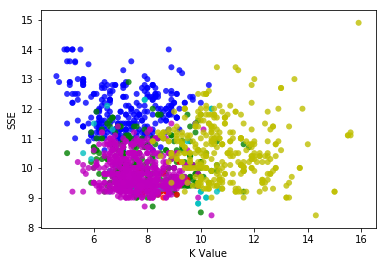

In [383]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
for data, color, group in zip(np.unique(clusters), colors, labels):
    print(data, color, group)
    x = wine_eda['fixed acidity'][np.where(clusters == data)[0]]
    y = wine_eda['alcohol'][np.where(clusters == data)[0]]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group) 
    ax.set_xlabel('K Value')
    ax.set_ylabel('SSE')

plt.show()
#plt.legend(loc=1)

<IPython.core.display.Javascript object>


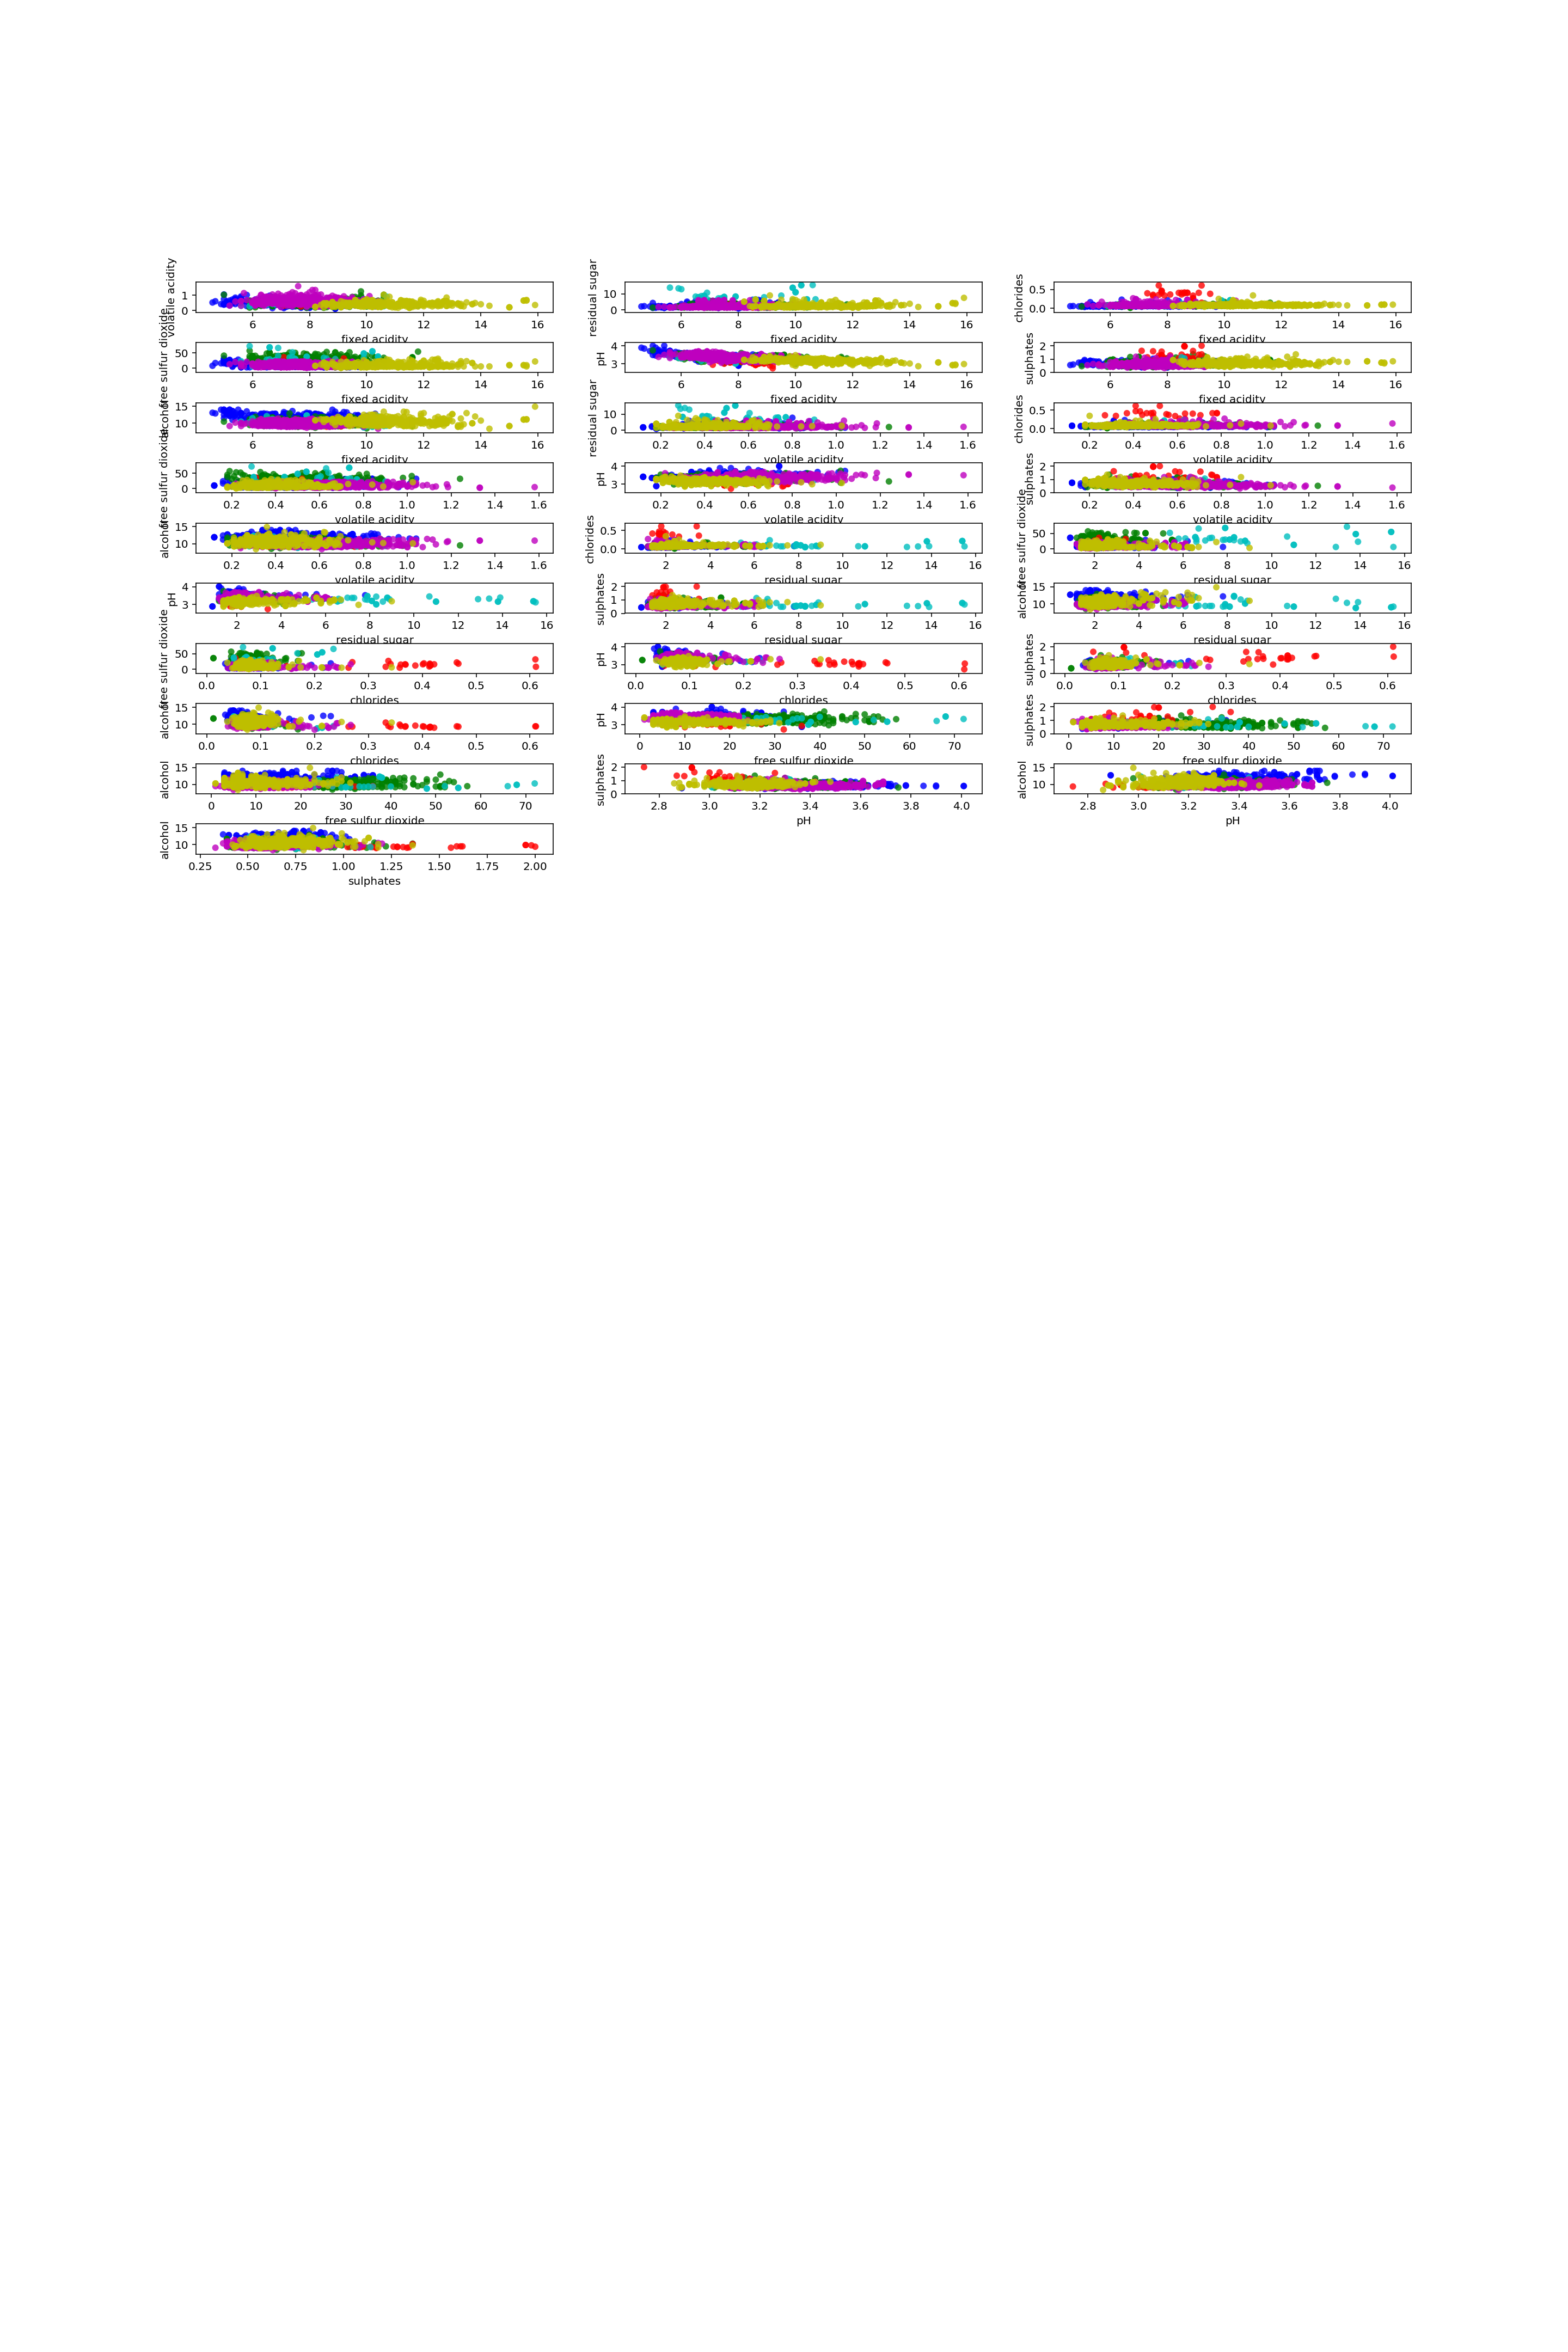

In [470]:
%matplotlib notebook

columns_list = []
for i in range(8):
    for j in range(i+1,8):
        #print(i,j)
        columns_list.append((wine_eda.columns[i], wine_eda.columns[j]))

plt.figure(figsize = (20, 30)).subplots_adjust(hspace=1)
counter = 0
for i,j in columns_list:
    counter += 1
    plt.subplot(30,3, counter)
    for data, color, group in zip(np.unique(clusters), colors, labels):
            x = wine_eda[i][np.where(clusters == data)[0]]
            y = wine_eda[j][np.where(clusters == data)[0]]
            plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)
            plt.xlabel(i)
            plt.ylabel(j)

        
plt.show()



<IPython.core.display.Javascript object>


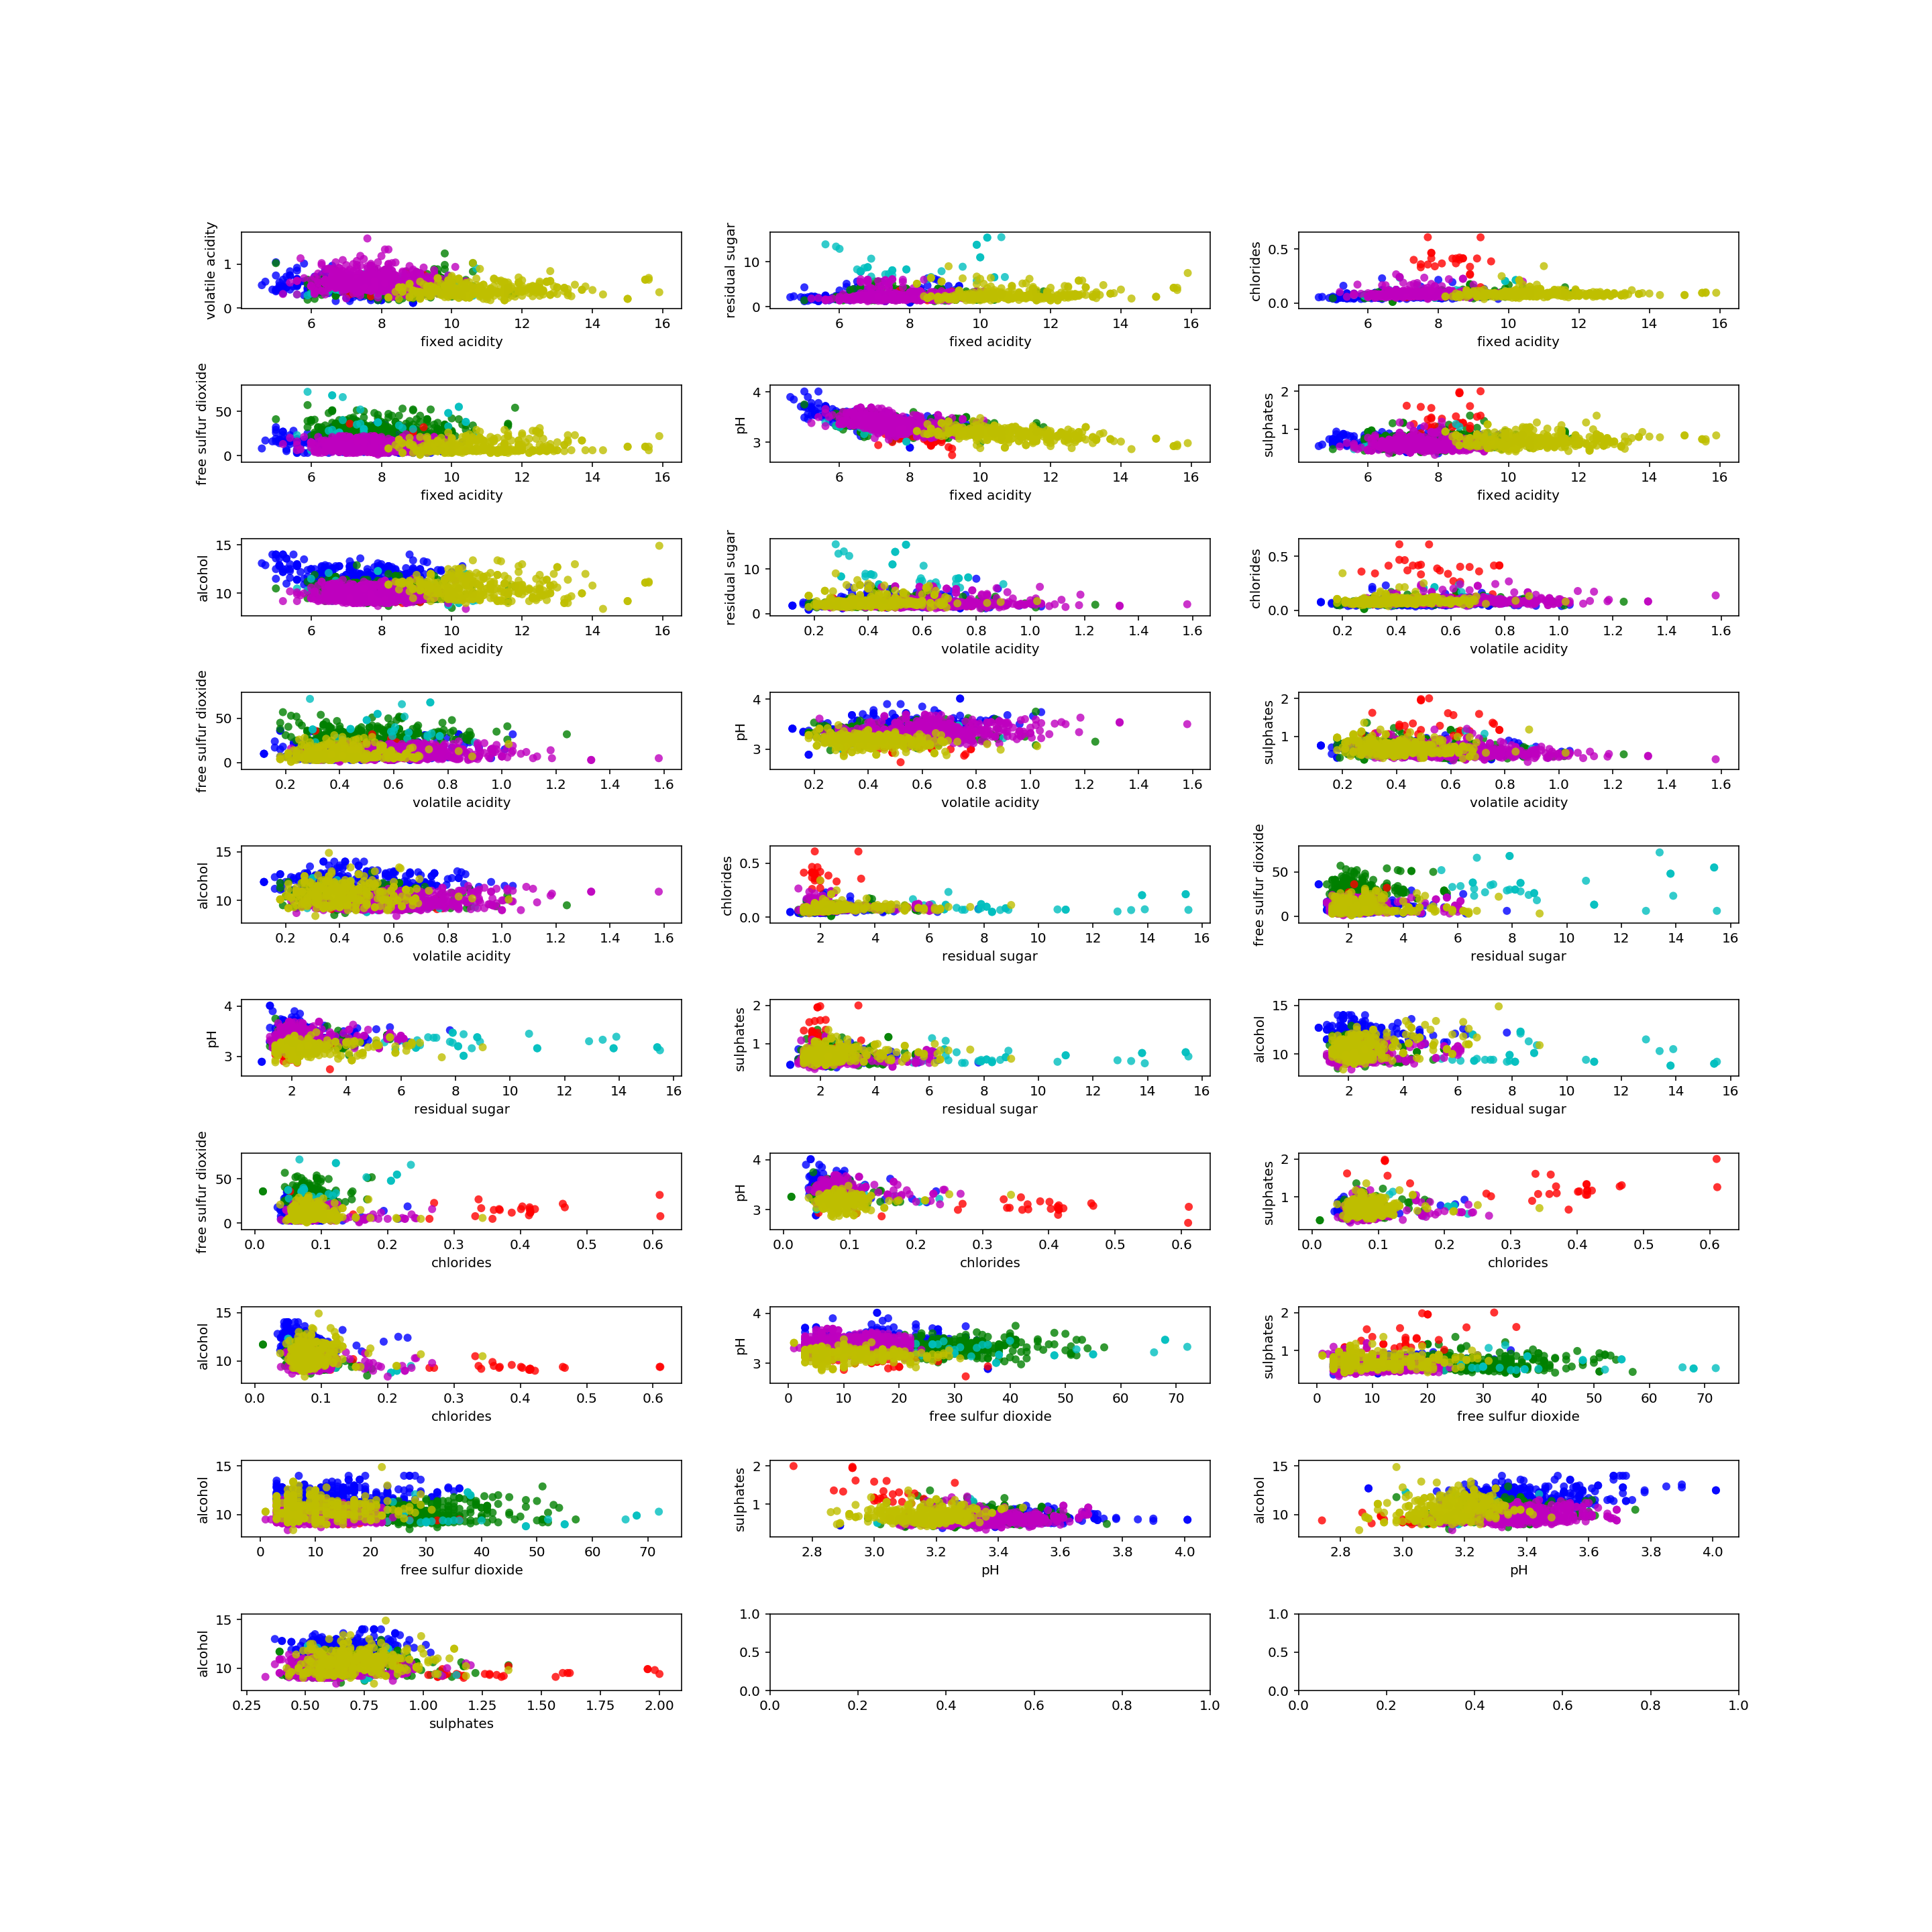

In [471]:
%matplotlib notebook

columns_list = []
for i in range(8):
    for j in range(i+1,8):
        #print(i,j)
        columns_list.append((wine_eda.columns[i], wine_eda.columns[j]))

#f = plt.figure(figsize = (20, 30)).subplots_adjust(hspace=1)
fig, axes = plt.subplots(10, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
#fig, ax = plt.subplots()
counter = -1
for i,j in columns_list:
    counter += 1
    for data, color, group in zip(np.unique(clusters), colors, labels):
            x = wine_eda[i][np.where(clusters == data)[0]]
            y = wine_eda[j][np.where(clusters == data)[0]]
            axes[int(counter/3),int(counter%3)].scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)
            axes[int(counter/3),int(counter%3)].set_xlabel(i)
            axes[int(counter/3),int(counter%3)].set_ylabel(j)
            #ax.plot()


        
plt.show()


## Off the Shelf

In [511]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansPack
KMS = KMeansPack(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Two)
SSE, SSB, SSE_cluster = calculateMeasures(Two, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

SSB : 83.031905
SSE : 137.662537
Cluster-wise SSE:
Cluster 1: 61.250000
Cluster 2: 32.320000
Cluster 3: 44.090000
Cluster 4: 0.000000


In [513]:

print('\nWine_Base')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))




Wine_Base
SSB : 22994.915231
SSE : 35424.495260

Wine_Norm
SSB : 346.396773
SSE : 560.735603

Wine_Softmax
SSB : 491.275252
SSE : 479.915766


In [515]:
k = 6
print('\nWine_Base')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, updateCentroids(Wine_Norm, KMS.labels_, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, updateCentroids(Wine_Softmax, KMS.labels_, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))




Wine_Base
SSB : 9996.298281
SSE : 3894.626869

Wine_Norm
SSB : 295.051116
SSE : 321.810498

Wine_Softmax
SSB : 475.223781
SSE : 87.884104


In [514]:

print('\nWine_Base')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))




Wine_Base
SSB : 21626.017147
SSE : 33600.862748

Wine_Norm
SSB : 307.851074
SSE : 532.973085

Wine_Softmax
SSB : 492.244607
SSE : 600.757717
